In [61]:
%load_ext autoreload
%autoreload 2

import dataclasses
import functools
import pathlib
import re
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import cast
import tree
from loguru import logger

from analysis.data import (iter_experiment_folder, load_file_contents,
                           load_yaml, set_dtypes)
from analysis.metrics import assign_aois, FixationMapping
from common import load_fixation_data, load_correctness_data
from analysis import plotting
from analysis import np_utils
import functools
from typing import Optional, Any, Sequence

from analysis.fixation_filters import (
    apply_fixation_filter,
    constrain_gaps_by_time,
    fixation_duration_threshold,
    remove_singletons,
    ivt,
    nn_interpolator,
    fixation_filter,
    GazeVector,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Processed Fixations

In [62]:

fixations = load_fixation_data()
correctness = load_correctness_data()

invalid_eyetracking_data = load_yaml("../data/raw/invalid_eyetracking_data.yaml")

for pid, tids in invalid_eyetracking_data.items():
    for tid in tids:
        target = (fixations['pid'] == pid) & (fixations['tid'] == tid)
        fixations = fixations[~target]

fixations_with_correctness = pd.merge(
    fixations,
    correctness,
    on=fixations.columns.intersection(correctness.columns).tolist(),
    how="inner",
)
annotations = load_yaml("../data/raw/annotations.yaml")
source_root = pathlib.Path("../data/raw/snippets")
source_index = {
    v["file"]: load_file_contents(source_root / v["file"])
    for k, v in annotations.items()
}

In [63]:
# fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
import seaborn.objects as so
import matplotlib as mpl
def draw_fixation_regions_over_gazes(
        gazes,
        fixations,
        *,
        gaze_time='plugin_time',
        fixation_time='plugin_time',
        y='source_file_line',
        duration='duration',
        fig=None
):
    if fig is None:
        fig = mpl.figure.Figure(figsize=(20, 5), dpi=150)

    p = so.Plot(data=gazes, x=gaze_time, y=y).add(so.Dots(marker="x", color="black"))
    p = p.scale(
        x=so.Continuous().tick(every=30 * 1e3).label(like=plotting.time_formatter())
    )
    p.on(fig).plot()
    ax = fig.axes[0]
    plotting.mark_ranges(
        plotting.ranges_from_fixations(
            fixations[fixation_time], fixations[duration]
        ),
        ax=ax,
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
    )

    return p

import fiddle as fdl
import fiddle.printing
def fiddle_config_fingerprint(cfg):
    str_repr = fiddle.printing.as_str_flattened(cfg)
    lines = [line for line in str_repr.splitlines() if not line.strip().endswith("<[unset]>")]
    return '\n'.join(lines)

def base_config(velocity_threshold=50, interpolation_radius=200, max_gap=200, min_duration=60):
    return fdl.Partial(
        fixation_filter,
        algorithm=fdl.Partial(ivt, velocity_threshold=velocity_threshold),
        interpolator=fdl.Partial(nn_interpolator, radius=interpolation_radius),
        transforms=[
            fdl.Partial(constrain_gaps_by_time, max_gap=max_gap),
            fdl.Partial(fixation_duration_threshold, min_duration=min_duration),
            remove_singletons,
        ],
    )



def get_fixations(df, cfg, show_config=True):
    if show_config:
        print(fiddle_config_fingerprint(cfg))
    return apply_fixation_filter(
        df,
        fdl.build(cfg),
        aggregations={
            ("left_pupil_diameter", "right_pupil_diameter"): "mean",
            ("gaze_target",): lambda x: x.iloc[0],
        },
    )


# Raw Gazes

In [64]:
core = pd.read_parquet("../data/raw/eyetracking/core.parq")
plugin = pd.read_parquet("../data/raw/eyetracking/plugin.parq")
eyetracking = pd.merge(core, plugin, on=core.columns.intersection(plugin.columns).tolist(), how="inner")

In [65]:
fixations.query('duration >= 2500')[['pid', 'tid', 'duration', 'plugin_time']].drop_duplicates().sort_values(
    by='duration',
    ascending=False,
)#[['pid', 'tid', ]].drop_duplicates().sort_values(by=['pid', 'tid'])


,,pid,tid,duration,plugin_time
521,0,p41,t3,5811.0,1.649976e+12
14709,0,p69,t1,4876.0,1.651257e+12
351,0,p45,t2,4556.0,1.650149e+12
1707,0,p15,t4,4198.0,1.636933e+12
1697,0,p15,t4,4172.0,1.636933e+12
569,0,p97,t3,3829.0,1.670283e+12
415,0,p97,t2,3817.0,1.670283e+12
815,0,p15,t4,3791.0,1.636933e+12
1509,0,p15,t4,3791.0,1.636933e+12
379,0,p97,t2,3668.0,1.670283e+12


In [55]:
def select_rows(**queries):
    def _apply_query(df):
        indexer = np.ones(len(df), dtype=bool)
        for col_name, query_value in queries.items():
            indexer &= df[col_name] == query_value
        return df[indexer]
    return _apply_query

selector = select_rows(
    pid='p46',
    tid='t2'
)

sample_core = selector(core).copy()
sample_plugin = selector(plugin).copy()
sample_fixations = selector(fixations).copy()
sample_fixations['plugin_time'] = sample_fixations['plugin_time'].astype(np.int64) 
sample_core = sample_core.assign(core_time=sample_core['core_time'] - sample_core['core_time'].min())
sample_plugin = sample_plugin.assign(plugin_time=sample_plugin['plugin_time'] - sample_plugin['plugin_time'].min())
sample_fixations = sample_fixations.assign(plugin_time=sample_fixations['plugin_time'] - sample_fixations['plugin_time'].min())

sample_eyetracking = pd.merge(sample_core, sample_plugin, on=sample_core.columns.intersection(sample_plugin.columns).tolist(), how="inner")


## Old Fixations

/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_60325/3941497557.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


algorithm.velocity_threshold: float = 50
interpolator.radius = 80
transforms[0].max_gap: float = 200
transforms[1].min_duration: float = 80
transforms[2] = <function remove_singletons at 0x28908b0a0>


/var/folders/9t/pnh1mqks36vfw7ngs3d7n8r00000gn/T/ipykernel_60325/3941497557.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


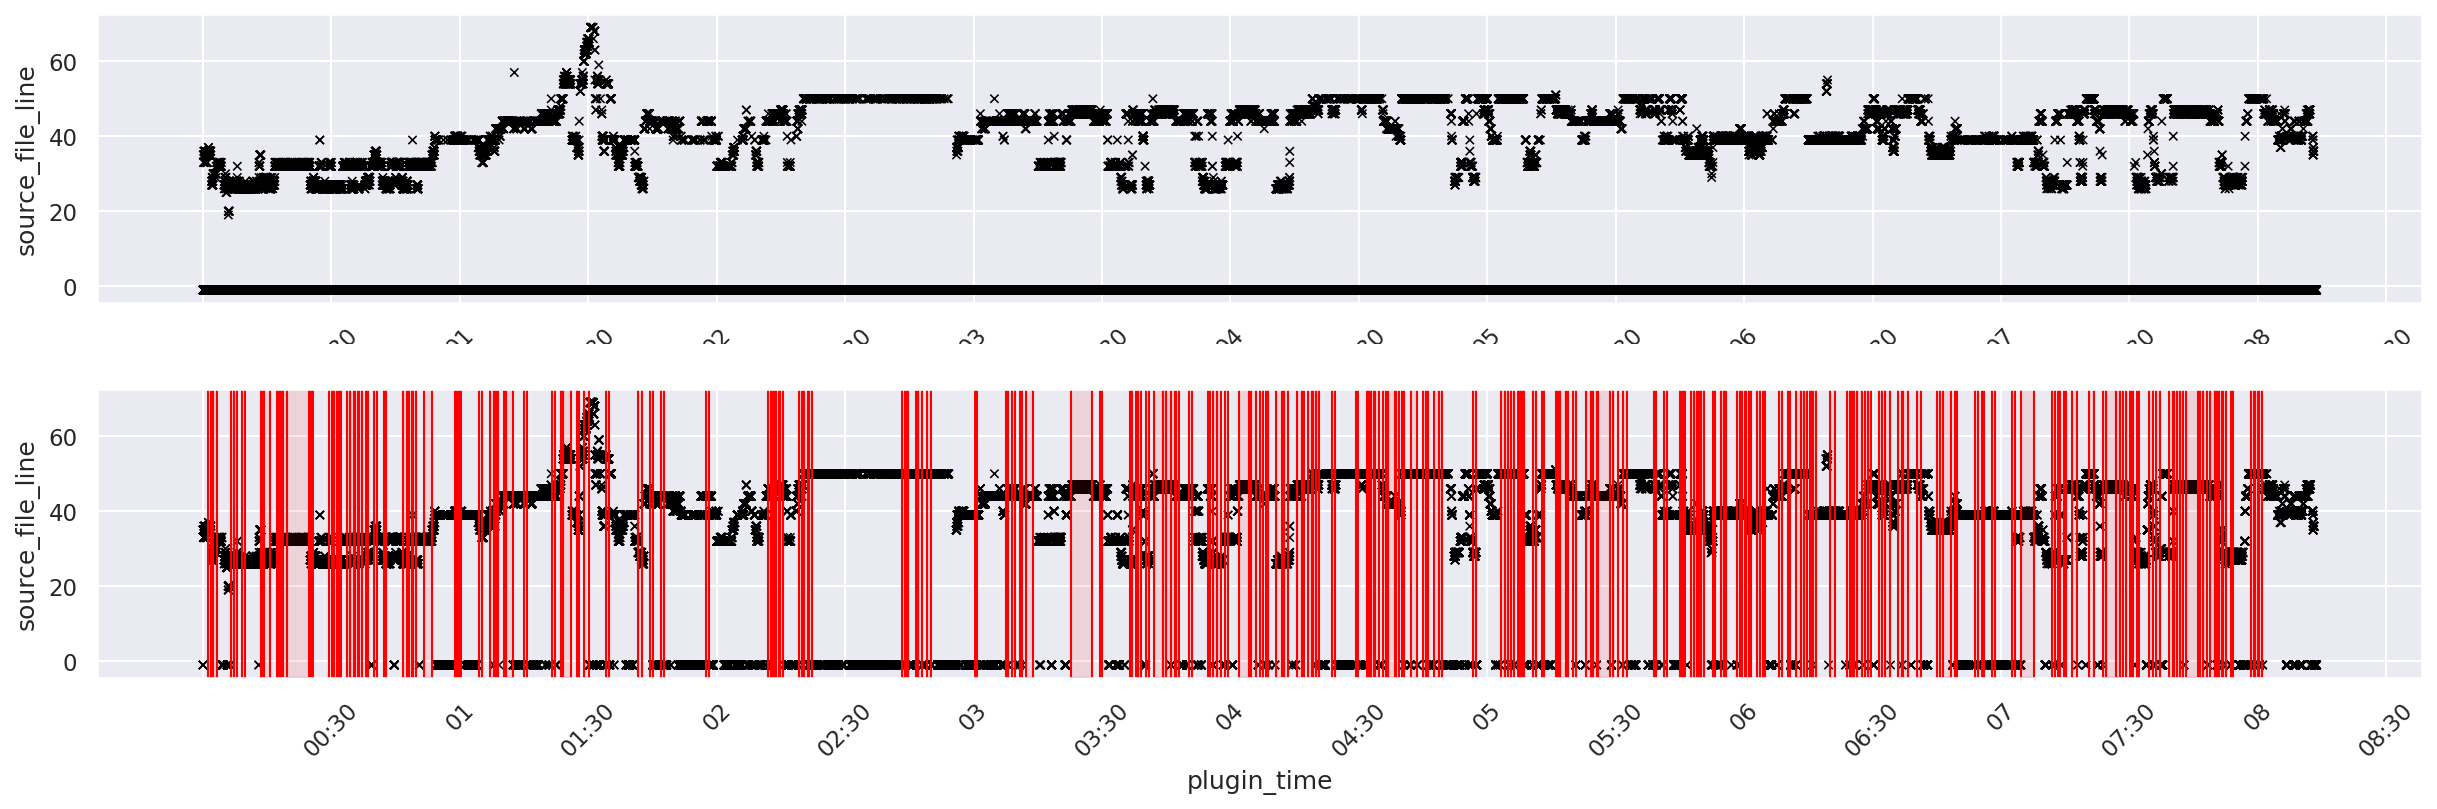

In [56]:
import seaborn.objects as so
from matplotlib import patches
import matplotlib as mpl
# fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
fig = mpl.figure.Figure(figsize=(20, 5), dpi=150)
sub_a, sub_b = fig.subfigures(2, 1,)
long_fixations = sample_fixations.query('duration > 500')
draw_fixation_regions_over_gazes(sample_plugin, long_fixations, fig=sub_a)

cfg = base_config(velocity_threshold=50, interpolation_radius=80, max_gap=200, min_duration=80)

annotated_gazes, new_fixations = get_fixations(sample_eyetracking, cfg)

draw_fixation_regions_over_gazes(annotated_gazes, new_fixations.query('duration > 500'), fixation_time='start_time', fig=sub_b)
fig
    

In [130]:

# fig
def zip_keys(df, keys):
    return zip(*[df[key]for key in keys])


import intervaltree
def interval_subsumes(a, b) -> bool:
    "Checks if A subsumes B."
    return a[0] <= b[0] and a[1] >= b[1]

def compute_overlaps(old_fixation_intervals, new_fixation_intervals):
    tree = intervaltree.IntervalTree()
    for idx, interval in enumerate(old_fixation_intervals):
        tree.addi(*interval, idx)
    
    splits = 0
    missing = 0
    overlaps = 0
    for new_fixation in new_fixation_intervals:
        overlapping = list(tree.overlap(*new_fixation))
        if not overlapping:
            missing += 1
        elif len(overlapping) == 1:
            if interval_subsumes(overlapping[0], new_fixation):
                overlaps += 1
            else:
                splits += 1
        elif len(overlapping) > 1:
            splits += 1
        else:
            raise Exception() 
    
    results = {'splits': splits, 'missing': missing, 'overlaps': overlaps}
    results = {k: v/len(new_fixation_intervals) for k, v in results.items()}
    return results 

from tqdm.auto import tqdm
def compute_overlaps_entire_dataset(cfg):
    results = []
    all_keys = list(zip_keys(fixations[['pid', 'tid']].drop_duplicates(), ['pid', 'tid']))
    bar = tqdm(all_keys)
    for pid, tid in bar:
        bar.set_description(f"{pid} {tid}")
        selector = select_rows(pid=pid, tid=tid)
        old_fixations = selector(fixations).copy()
        old_fixations['plugin_time'] = old_fixations['plugin_time'].astype(np.int64) 
        # old_fixations = old_fixations.assign(plugin_time=old_fixations['plugin_time'] - old_fixations['plugin_time'].min())

        sample_eyetracking = selector(eyetracking).copy()
        _, new_fixations = get_fixations(sample_eyetracking.sort_values(by='plugin_time'), cfg, show_config=False)

        old_intervals = [(start, start + duration) for start, duration in zip_keys(old_fixations, ['plugin_time', 'duration'])]
        new_intervals = [(start, start + duration) for start, duration in zip_keys(new_fixations, ['start_time', 'duration'])]

        # print(new_intervals[:5])
        # print(old_intervals[:5])
        result = compute_overlaps(old_intervals, new_intervals)
        result['pid'] = pid
        result['tid'] = tid
        results.append(result)
    return results

import itertools
def perform_grid_search(grid, n=-1):
    results = []
    config_values = list(itertools.product(*grid.values()))
    if n > 0:
        config_values = config_values[:n]

    for i, values in enumerate(config_values):
        print(f"Running {i+1}/{len(config_values)}")
        cfg = dict(zip(grid.keys(), values))
        result = compute_overlaps_entire_dataset(base_config(**cfg))
        results.append((cfg, result))
    return results

config_grid = {
    'velocity_threshold': [50],
    'interpolation_radius': [80, 100,  200],
    'max_gap': [80, 100,  200],
    'min_duration': [60, 80],
}

grid_search_results = perform_grid_search(config_grid)
# r = compute_overlaps_entire_dataset()
# compute_overlaps(old_intervals, new_intervals)
# new_intervals

Running 1/18


p99 t4: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]    


Running 2/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 3/18


p99 t4: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]    


Running 4/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 5/18


p99 t4: 100%|██████████| 219/219 [02:46<00:00,  1.31it/s]    


Running 6/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 7/18


p99 t4: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]    


Running 8/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 9/18


p99 t4: 100%|██████████| 219/219 [02:46<00:00,  1.31it/s]    


Running 10/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 11/18


p99 t4: 100%|██████████| 219/219 [02:46<00:00,  1.31it/s]    


Running 12/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 13/18


p99 t4: 100%|██████████| 219/219 [02:46<00:00,  1.31it/s]    


Running 14/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 15/18


p99 t4: 100%|██████████| 219/219 [02:48<00:00,  1.30it/s]    


Running 16/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


Running 17/18


p99 t4: 100%|██████████| 219/219 [02:47<00:00,  1.31it/s]    


Running 18/18


p99 t4: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]    


In [149]:
old_fixations = fixations.copy()

In [273]:
new_fixations = eyetracking.groupby(["pid", "tid"]).apply(
    lambda df: get_fixations(df.sort_values(by='plugin_time'), base_config(
        velocity_threshold=50,
        interpolation_radius=80,
        max_gap=80,
        min_duration=80,
    ), show_config=False)[1],
)
new_fixations = new_fixations.reset_index(level=2)

## Manual validation for ziyi

In [270]:
keys = [
    ('p102', 't2'),
    ('p79', 't3'),
    ('p93', 't2'),
    ('p85', 't1'),
    ('p79', 't2'),
    ('p66', 't3')
]

vitalse_cols = set(df.columns)
new_cols = set(new_fixations.columns)

# vitalse_cols - new_cols


# new_fixations.loc[keys[0]]
new_fixations.index.unique()


MultiIndex([( 'p10', 't1'),
            ( 'p10', 't2'),
            ( 'p10', 't3'),
            ( 'p10', 't4'),
            ('p100', 't2'),
            ('p100', 't3'),
            ('p100', 't4'),
            ('p101', 't1'),
            ('p101', 't2'),
            ('p101', 't3'),
            ...
            ( 'p97', 't1'),
            ( 'p97', 't2'),
            ( 'p97', 't3'),
            ( 'p97', 't4'),
            ( 'p98', 't3'),
            ( 'p98', 't4'),
            ( 'p99', 't1'),
            ( 'p99', 't2'),
            ( 'p99', 't3'),
            ( 'p99', 't4')],
           names=['pid', 'tid'], length=314)

In [83]:
import pandas as pd
import pathlib
from result import Ok, Err, OkErr
from analysis.data import iter_experiment_folder, iter_experiment_dir
import datetime


def get_timestamp_str():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

def export_fixations_for_vitalse(fixations: pd.DataFrame, prefix: str = ''):

    experiment_root = pathlib.Path("/Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/")
    renames = {
        'start_time': 'system_time',
        'gaze_target': 'target',
    }

    for key in fixations.index.unique():
        outputs = fixations.loc[key].rename(renames, axis=1).copy()
        outputs['source_file_line'] += 1
        pid, tid = key
        outpath = experiment_root / pid / tid / 'processed-new'
        if outpath.exists():
            print(f'Writing to {str(outpath)}')
            outputs.to_json(outpath / f"fixations_{prefix}.json", orient='records')
        else:
            print(f'Skipping {str(outpath)}')

fixations_to_export = pd.read_parquet('../data/processed/fixations-fixed.parq').reset_index(level=2)
export_fixations_for_vitalse(fixations_to_export, prefix=get_timestamp_str())
# fixations_to_export

Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p10/t1/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p10/t2/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p10/t3/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p10/t4/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p100/t2/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p100/t3/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p100/t4/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p101/t1/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p101/t2/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p101/t3/processed-new
Writing to /Users/devjeetroy/OneDrive/ReadingStrategyExperiemntData/p101/t4/processed-new
Writing to /Us

In [266]:
new_fixations.loc[('p102', 't2')]

fixation_id  left_pupil_diameter  right_pupil_diameter  \
pid  tid                                                           
p102 t2           0.0            20.520990             20.650770   
     t2           1.0            21.595288             23.414981   
     t2           2.0            21.404171             23.255656   
     t2           3.0            20.977667             21.794001   
     t2           4.0            21.967741             22.210624   
...               ...                  ...                   ...   
     t2         330.0            19.118002             19.949232   
     t2         331.0            19.251715             19.507430   
     t2         332.0            19.108643             20.391867   
     t2         333.0            19.475293             19.595185   
     t2         334.0            19.491274             19.338150   

                     gaze_target  valid  interpolated   n    start_time  \
pid  tid                                                                  
p102 t2   rectangle-with-bug.cpp    1.0            49  50  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0            35  48  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0             5   7  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0             5  16  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0             6  11  1.670457e+12   
...                          ...    ...           ...  ..           ...   
     t2   rectangle-with-bug.cpp    1.0             6   9  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0            28  33  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0            33  35  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0            31  33  1.670457e+12   
     t2   rectangle-with-bug.cpp    1.0            29  31  1.670457e+12   

              end_time  duration  source_file_line  source_file_col  
pid  tid                                                             
p102 t2   1.670457e+12     379.0                23               14  
     t2   1.670457e+12     389.0                40               26  
     t2   1.670457e+12      60.0                40               22  
     t2   1.670457e+12     110.0                40               15  
     t2   1.670457e+12      87.0                40                8  
...                ...       ...               ...              ...  
     t2   1.670457e+12      65.0                15               22  
     t2   1.670457e+12     269.0                15               31  
     t2   1.670457e+12     265.0                15               22  
     t2   1.670457e+12     277.0                10               22  
     t2   1.670457e+12     234.0                10               14  

[335 rows x 12 columns]

In [48]:
new_fixations = pd.read_parquet('../data/processed/fixations-new.parq').reset_index(level=2)
invalid_eyetracking_data = load_yaml("../data/raw/invalid_eyetracking_data.yaml")

for pid, tids in invalid_eyetracking_data.items():
    for tid in tids:
        new_fixations = new_fixations.drop((pid, tid))

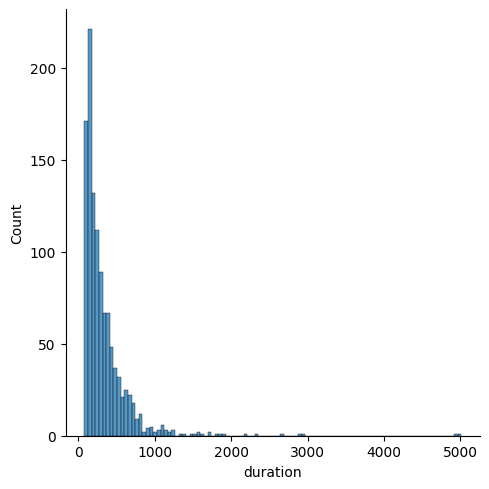

In [60]:
sns.displot(data=new_fixations, x='duration')

In [32]:
eyetracking

NameError: name 'eyetracking' is not defined